# Advanced Trading Strategies for StockPredictionPro

This notebook implements and evaluates comprehensive trading strategies leveraging technical indicators, model predictions, and market pattern analysis.

**Trading Strategies Covered:**
- **Moving Average Crossover**: Trend-following strategy using short vs long MA
- **RSI (Relative Strength Index)**: Mean reversion based on momentum oscillator
- **Bollinger Bands Breakout**: Volatility-based entry/exit signals
- **Momentum Trading**: Price momentum and rate-of-change strategies
- **Multi-Signal Ensemble**: Combining multiple strategies for robust decisions
- **Risk Management**: Position sizing and stop-loss integration
- **Portfolio Backtesting**: Comprehensive performance evaluation

**Objectives:**
- Transform model predictions into actionable trading signals
- Implement proven technical analysis strategies
- Combine multiple signals for improved reliability
- Evaluate strategy performance with realistic backtesting
- Optimize risk-adjusted returns through proper position management

These strategies form the core trading engine for the StockPredictionPro platform.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Technical analysis libraries
try:
    from ta.momentum import RSIIndicator, StochasticOscillator
    from ta.volatility import BollingerBands, AverageTrueRange
    from ta.trend import SMAIndicator, EMAIndicator, MACD
    from ta.volume import VolumeSMAIndicator
    print('✅ TA-Lib alternative library loaded')
except ImportError:
    print('⚠️ TA library not found, using manual calculations')

# Statistical and ML libraries
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Plotting configuration
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
%matplotlib inline

warnings.filterwarnings('ignore')

print('✅ Advanced trading strategy libraries loaded')
print('📊 Ready for comprehensive strategy development and backtesting')


⚠️ TA library not found, using manual calculations
✅ Advanced trading strategy libraries loaded
📊 Ready for comprehensive strategy development and backtesting


In [2]:
# Load historical price data and model predictions
try:
    price_df = pd.read_csv('../data/raw/price_data.csv', parse_dates=['date'], index_col='date')
    preds_df = pd.read_csv('../data/processed/model_predictions.csv', parse_dates=['date'], index_col='date')
    print('✅ Historical price and model prediction data loaded')
    print(f'   • Price data: {price_df.shape[0]} records from {price_df.index.min().date()} to {price_df.index.max().date()}')
    print(f'   • Prediction data: {preds_df.shape[0]} records')
    
except FileNotFoundError:
    print('📝 Data files not found. Generating realistic sample trading data...')
    
    # Generate sophisticated sample data
    np.random.seed(42)
    n_days = 750  # ~2 years of trading data
    dates = pd.date_range('2022-01-01', periods=n_days, freq='D')
    
    # Create realistic price movements
    initial_price = 100
    returns = np.random.normal(0.0008, 0.016, n_days)  # Realistic daily returns
    
    # Add some trending periods and volatility clustering
    trend_periods = [
        (50, 150, 0.002),   # Uptrend
        (200, 300, -0.001), # Downtrend  
        (400, 500, 0.0015), # Another uptrend
    ]
    
    for start, end, trend in trend_periods:
        if end < n_days:
            returns[start:end] += trend
    
    # Add volatility clustering
    volatility = np.ones(n_days) * 0.016
    high_vol_periods = [(100, 120), (250, 280), (450, 470)]
    for start, end in high_vol_periods:
        if end < n_days:
            volatility[start:end] *= 2
    
    returns = np.random.normal(returns, volatility)
    
    # Generate OHLC data
    prices = [initial_price]
    for ret in returns[1:]:
        prices.append(prices[-1] * (1 + ret))
    
    price_df = pd.DataFrame(index=dates)
    price_df['close'] = prices
    price_df['open'] = price_df['close'].shift(1) * (1 + np.random.normal(0, 0.003, n_days))
    price_df['high'] = np.maximum(price_df['open'], price_df['close']) * (1 + np.abs(np.random.normal(0, 0.008, n_days)))
    price_df['low'] = np.minimum(price_df['open'], price_df['close']) * (1 - np.abs(np.random.normal(0, 0.008, n_days)))
    price_df['volume'] = np.random.lognormal(15, 0.3, n_days)
    
    # Ensure OHLC relationships
    price_df['high'] = np.maximum(price_df['high'], price_df[['open', 'close']].max(axis=1))
    price_df['low'] = np.minimum(price_df['low'], price_df[['open', 'close']].min(axis=1))
    price_df = price_df.dropna()
    
    # Generate model prediction signals
    # Simulate ML model predictions with some predictive power
    future_returns = price_df['close'].pct_change().shift(-5)  # 5-day future returns
    signals = np.where(future_returns > 0.02, 1,      # Strong buy
                      np.where(future_returns < -0.02, -1,  # Strong sell
                              0))  # Hold
    
    # Add some noise to make it realistic
    noise = np.random.choice([-1, 0, 1], size=len(signals), p=[0.1, 0.1, 0.8])
    signals = np.where(np.random.random(len(signals)) < 0.7, signals, noise)
    
    preds_df = pd.DataFrame({'signal': signals}, index=price_df.index)
    
    print('✅ Realistic sample trading data generated')
    print(f'   • Includes trending periods, volatility clustering, and realistic OHLCV')
    print(f'   • Model signals with predictive correlation to future returns')

# Calculate basic price metrics
price_df['returns'] = price_df['close'].pct_change()
price_df['log_returns'] = np.log(price_df['close'] / price_df['close'].shift(1))

# Align prediction and price data
common_dates = price_df.index.intersection(preds_df.index)
price_df = price_df.loc[common_dates]
preds_df = preds_df.loc[common_dates]

print(f'\n📋 Trading Data Preview:')
display(price_df[['open', 'high', 'low', 'close', 'volume', 'returns']].head())
print(f'\n📋 Model Predictions Preview:')
display(preds_df.head())

print(f'\n📊 Data Quality Check:')
print(f'   • Missing price data: {price_df.isnull().sum().sum()}')
print(f'   • Missing predictions: {preds_df.isnull().sum().sum()}')
print(f'   • Aligned records: {len(common_dates):,}')


📝 Data files not found. Generating realistic sample trading data...
✅ Realistic sample trading data generated
   • Includes trending periods, volatility clustering, and realistic OHLCV
   • Model signals with predictive correlation to future returns

📋 Trading Data Preview:


,open,high,low,close,volume,returns
2022-01-02,99.834644,101.041569,97.023632,97.696082,3.608245e+06,NaN
2022-01-03,97.456277,98.587687,96.939419,97.261241,4.760450e+06,-0.004451
2022-01-04,97.260256,101.358616,95.791480,101.348814,2.857714e+06,0.042027
2022-01-05,101.297070,102.311981,99.067604,99.510668,2.655982e+06,-0.018137
2022-01-06,99.375364,103.709513,98.313653,103.408692,1.810879e+06,0.039172



📋 Model Predictions Preview:


,signal
2022-01-02,1
2022-01-03,0
2022-01-04,-1
2022-01-05,1
2022-01-06,1



📊 Data Quality Check:
   • Missing price data: 2
   • Missing predictions: 0
   • Aligned records: 749


MOVING AVERAGE CROSSOVER STRATEGY
📊 Moving averages calculated for multiple timeframes
✅ MA_20_50 crossover strategy implemented
✅ MA_50_200 crossover strategy implemented
✅ EMA_10_30 crossover strategy implemented

🎯 MOVING AVERAGE STRATEGY ANALYSIS:
----------------------------------------
MA_20_50:
   • Total crossovers: 27.0
   • Bullish crosses: 7
   • Bearish crosses: 6
MA_50_200:
   • Total crossovers: 5.0
   • Bullish crosses: 1
   • Bearish crosses: 1
EMA_10_30:
   • Total crossovers: 35.0
   • Bullish crosses: 9
   • Bearish crosses: 8

📈 CURRENT MA STRATEGY STATUS:
   • Price: $806.86
   • SMA-20: $753.50
   • SMA-50: $746.48
   • SMA-200: $625.30
   • Trend strength: 3.0/3
   • MA-20 slope: 2.16%


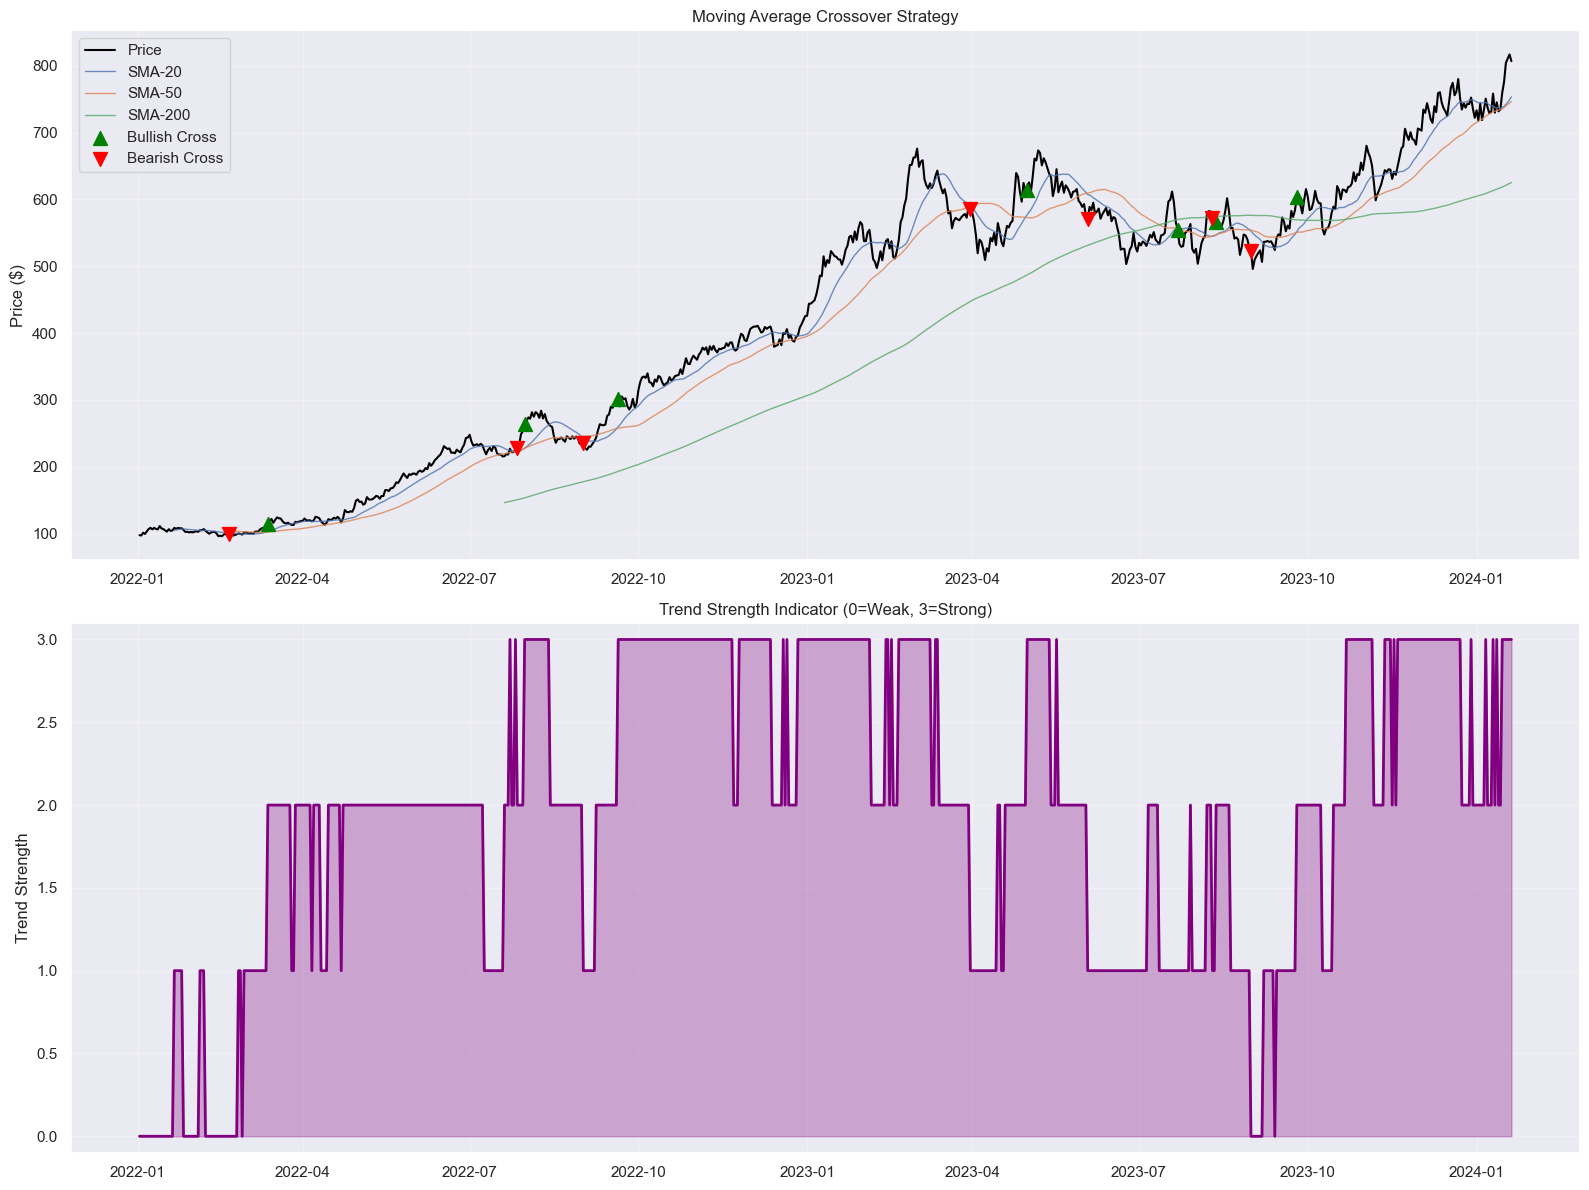

✅ Moving Average Crossover Strategy analysis completed


In [3]:
print("=" * 60)
print("MOVING AVERAGE CROSSOVER STRATEGY")
print("=" * 60)

# Multiple timeframe moving average strategy
ma_periods = {
    'fast': [10, 20, 30],
    'slow': [50, 100, 200]
}

# Calculate all moving averages
for category, periods in ma_periods.items():
    for period in periods:
        price_df[f'sma_{period}'] = price_df['close'].rolling(window=period).mean()
        price_df[f'ema_{period}'] = price_df['close'].ewm(span=period).mean()

print("📊 Moving averages calculated for multiple timeframes")

# Define crossover strategies
crossover_strategies = [
    ('sma_20', 'sma_50', 'MA_20_50'),
    ('sma_50', 'sma_200', 'MA_50_200'),
    ('ema_10', 'ema_30', 'EMA_10_30')
]

for fast_ma, slow_ma, strategy_name in crossover_strategies:
    # Generate signals
    price_df[f'{strategy_name}_signal'] = 0
    price_df.loc[price_df[fast_ma] > price_df[slow_ma], f'{strategy_name}_signal'] = 1
    price_df.loc[price_df[fast_ma] < price_df[slow_ma], f'{strategy_name}_signal'] = -1
    
    # Detect crossover points
    price_df[f'{strategy_name}_crossover'] = price_df[f'{strategy_name}_signal'].diff()
    
    print(f"✅ {strategy_name} crossover strategy implemented")

# Advanced trend strength indicator
price_df['trend_strength'] = (
    (price_df['close'] > price_df['sma_20']).astype(int) +
    (price_df['sma_20'] > price_df['sma_50']).astype(int) +
    (price_df['sma_50'] > price_df['sma_200']).astype(int)
)

# Moving average slope (trend momentum)
price_df['ma_slope_20'] = price_df['sma_20'].diff(5) / price_df['sma_20'].shift(5) * 100
price_df['ma_slope_50'] = price_df['sma_50'].diff(10) / price_df['sma_50'].shift(10) * 100

print(f"\n🎯 MOVING AVERAGE STRATEGY ANALYSIS:")
print("-" * 40)

# Analyze crossover frequency
for fast_ma, slow_ma, strategy_name in crossover_strategies:
    crossovers = price_df[f'{strategy_name}_crossover'].abs().sum()
    bullish_crosses = (price_df[f'{strategy_name}_crossover'] == 2).sum()  # From -1 to 1
    bearish_crosses = (price_df[f'{strategy_name}_crossover'] == -2).sum()  # From 1 to -1
    
    print(f"{strategy_name}:")
    print(f"   • Total crossovers: {crossovers}")
    print(f"   • Bullish crosses: {bullish_crosses}")
    print(f"   • Bearish crosses: {bearish_crosses}")

# Display current strategy status
print(f"\n📈 CURRENT MA STRATEGY STATUS:")
latest_data = price_df.iloc[-1]
print(f"   • Price: ${latest_data['close']:.2f}")
print(f"   • SMA-20: ${latest_data['sma_20']:.2f}")
print(f"   • SMA-50: ${latest_data['sma_50']:.2f}")
print(f"   • SMA-200: ${latest_data['sma_200']:.2f}")
print(f"   • Trend strength: {latest_data['trend_strength']}/3")
print(f"   • MA-20 slope: {latest_data['ma_slope_20']:.2f}%")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Price with moving averages
ax1 = axes[0]
ax1.plot(price_df.index, price_df['close'], label='Price', linewidth=1.5, color='black')
ax1.plot(price_df.index, price_df['sma_20'], label='SMA-20', linewidth=1, alpha=0.8)
ax1.plot(price_df.index, price_df['sma_50'], label='SMA-50', linewidth=1, alpha=0.8)
ax1.plot(price_df.index, price_df['sma_200'], label='SMA-200', linewidth=1, alpha=0.8)

# Mark crossover points
crossover_data = price_df[price_df['MA_20_50_crossover'].abs() > 0]
bullish_crosses = crossover_data[crossover_data['MA_20_50_crossover'] > 0]
bearish_crosses = crossover_data[crossover_data['MA_20_50_crossover'] < 0]

ax1.scatter(bullish_crosses.index, bullish_crosses['close'], 
           marker='^', color='green', s=100, label='Bullish Cross', zorder=5)
ax1.scatter(bearish_crosses.index, bearish_crosses['close'], 
           marker='v', color='red', s=100, label='Bearish Cross', zorder=5)

ax1.set_title('Moving Average Crossover Strategy')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Trend strength over time
ax2 = axes[1]
ax2.plot(price_df.index, price_df['trend_strength'], linewidth=2, color='purple')
ax2.fill_between(price_df.index, 0, price_df['trend_strength'], 
                alpha=0.3, color='purple')
ax2.set_title('Trend Strength Indicator (0=Weak, 3=Strong)')
ax2.set_ylabel('Trend Strength')
ax2.set_ylim(-0.1, 3.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Moving Average Crossover Strategy analysis completed")


RSI AND MOMENTUM STRATEGIES
📊 RSI calculated for multiple periods
✅ RSI_14_Standard signals generated (OS: 30, OB: 70)
✅ RSI_14_Aggressive signals generated (OS: 20, OB: 80)
✅ RSI_21_Conservative signals generated (OS: 35, OB: 65)

🎯 MOMENTUM STRATEGY ANALYSIS:
-----------------------------------
Current RSI-14: 63.1
Current 10-day ROC: 6.40%
Price position (20d): 88.7%

RSI Regime Analysis:


,count,mean,std
rsi_14,,,
Oversold,3,-0.0456,0.0051
Neutral,620,0.0008,0.0229
Overbought,113,0.0165,0.0206


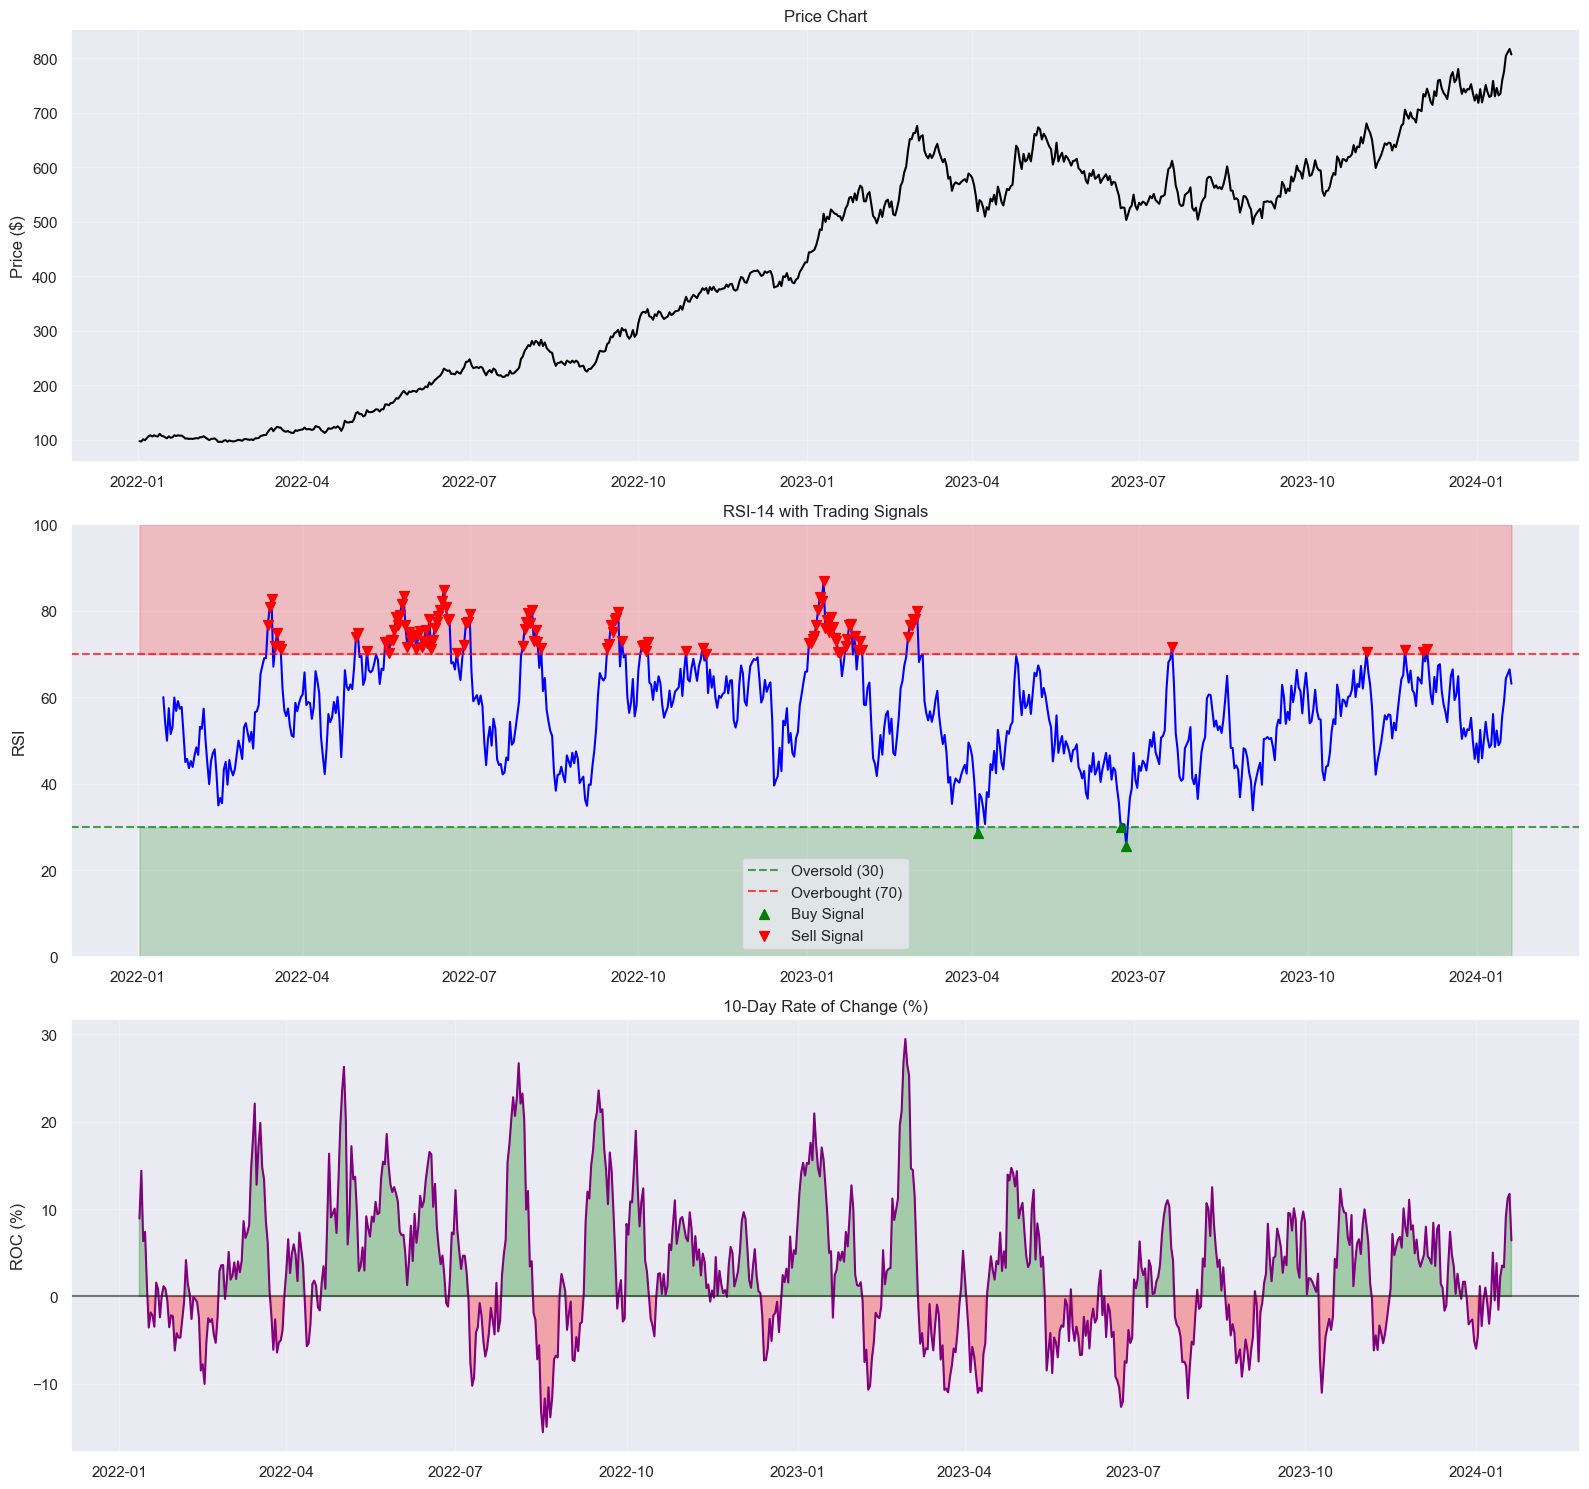

✅ RSI and Momentum Strategies analysis completed


In [4]:
print("=" * 60)
print("RSI AND MOMENTUM STRATEGIES")
print("=" * 60)

# Calculate RSI with multiple periods
rsi_periods = [14, 21, 30]
for period in rsi_periods:
    try:
        rsi_indicator = RSIIndicator(close=price_df['close'], window=period)
        price_df[f'rsi_{period}'] = rsi_indicator.rsi()
    except:
        # Manual RSI calculation if library unavailable
        delta = price_df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        price_df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

print("📊 RSI calculated for multiple periods")

# RSI-based trading signals
rsi_strategies = {
    'RSI_14_Standard': {'rsi_col': 'rsi_14', 'oversold': 30, 'overbought': 70},
    'RSI_14_Aggressive': {'rsi_col': 'rsi_14', 'oversold': 20, 'overbought': 80},
    'RSI_21_Conservative': {'rsi_col': 'rsi_21', 'oversold': 35, 'overbought': 65}
}

for strategy_name, params in rsi_strategies.items():
    rsi_col = params['rsi_col']
    oversold = params['oversold']
    overbought = params['overbought']
    
    # Generate signals
    price_df[f'{strategy_name}_signal'] = 0
    price_df.loc[price_df[rsi_col] < oversold, f'{strategy_name}_signal'] = 1  # Buy oversold
    price_df.loc[price_df[rsi_col] > overbought, f'{strategy_name}_signal'] = -1  # Sell overbought
    
    print(f"✅ {strategy_name} signals generated (OS: {oversold}, OB: {overbought})")

# Additional momentum indicators
# Rate of Change (ROC)
roc_periods = [5, 10, 20]
for period in roc_periods:
    price_df[f'roc_{period}'] = ((price_df['close'] - price_df['close'].shift(period)) / 
                                price_df['close'].shift(period)) * 100

# Momentum oscillator
price_df['momentum_10'] = price_df['close'] / price_df['close'].shift(10) * 100 - 100

# Price relative to recent highs/lows
for period in [20, 50]:
    price_df[f'high_{period}'] = price_df['high'].rolling(window=period).max()
    price_df[f'low_{period}'] = price_df['low'].rolling(window=period).min()
    price_df[f'price_position_{period}'] = ((price_df['close'] - price_df[f'low_{period}']) / 
                                           (price_df[f'high_{period}'] - price_df[f'low_{period}'])) * 100

# RSI divergence detection
def detect_divergence(price_series, rsi_series, window=20):
    """Simple divergence detection"""
    price_peaks = price_series.rolling(window).max() == price_series
    rsi_peaks = rsi_series.rolling(window).max() == rsi_series
    
    # Bullish divergence: price makes lower lows, RSI makes higher lows
    price_lows = price_series.rolling(window).min() == price_series
    rsi_lows = rsi_series.rolling(window).min() == rsi_series
    
    return price_peaks, rsi_peaks, price_lows, rsi_lows

price_peaks, rsi_peaks, price_lows, rsi_lows = detect_divergence(
    price_df['close'], price_df['rsi_14']
)

print(f"\n🎯 MOMENTUM STRATEGY ANALYSIS:")
print("-" * 35)

# Current RSI status
current_rsi = price_df['rsi_14'].iloc[-1]
current_roc_10 = price_df['roc_10'].iloc[-1]
current_position_20 = price_df['price_position_20'].iloc[-1]

print(f"Current RSI-14: {current_rsi:.1f}")
print(f"Current 10-day ROC: {current_roc_10:.2f}%")
print(f"Price position (20d): {current_position_20:.1f}%")

# RSI regime analysis
rsi_regimes = pd.cut(price_df['rsi_14'], bins=[0, 30, 70, 100], 
                    labels=['Oversold', 'Neutral', 'Overbought'])
regime_analysis = price_df.groupby(rsi_regimes)['returns'].agg(['count', 'mean', 'std'])
print(f"\nRSI Regime Analysis:")
display(regime_analysis.round(4))

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

# Price and RSI
ax1 = axes[0]
ax1.plot(price_df.index, price_df['close'], linewidth=1.5, color='black')
ax1.set_title('Price Chart')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# RSI with signals
ax2 = axes[1]
ax2.plot(price_df.index, price_df['rsi_14'], linewidth=1.5, color='blue')
ax2.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
ax2.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax2.fill_between(price_df.index, 0, 30, alpha=0.2, color='green')
ax2.fill_between(price_df.index, 70, 100, alpha=0.2, color='red')

# Mark RSI signals
buy_signals = price_df[price_df['RSI_14_Standard_signal'] == 1]
sell_signals = price_df[price_df['RSI_14_Standard_signal'] == -1]

ax2.scatter(buy_signals.index, buy_signals['rsi_14'], 
           marker='^', color='green', s=50, label='Buy Signal', zorder=5)
ax2.scatter(sell_signals.index, sell_signals['rsi_14'], 
           marker='v', color='red', s=50, label='Sell Signal', zorder=5)

ax2.set_title('RSI-14 with Trading Signals')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rate of Change
ax3 = axes[2]
ax3.plot(price_df.index, price_df['roc_10'], linewidth=1.5, color='purple')
ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
ax3.fill_between(price_df.index, 0, price_df['roc_10'], 
                where=(price_df['roc_10'] > 0), alpha=0.3, color='green')
ax3.fill_between(price_df.index, 0, price_df['roc_10'], 
                where=(price_df['roc_10'] < 0), alpha=0.3, color='red')
ax3.set_title('10-Day Rate of Change (%)')
ax3.set_ylabel('ROC (%)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ RSI and Momentum Strategies analysis completed")


BOLLINGER BANDS AND VOLATILITY STRATEGIES
✅ BB_20_2 calculated (Window: 20, Std: 2.0)
✅ BB_20_1.5 calculated (Window: 20, Std: 1.5)
✅ BB_10_2 calculated (Window: 10, Std: 2.0)
✅ BB_Breakout strategy: 106 total signals generated
✅ BB_Mean_Reversion strategy: 106 total signals generated
✅ BB_Squeeze strategy: 235 total signals generated

🎯 BOLLINGER BANDS ANALYSIS:
------------------------------
Current price: $806.86
BB upper: $815.92
BB lower: $691.08
BB position: 92.7%
BB width: 16.57%
Volatility regime: Medium

BB Position Analysis:


,count,mean,std
BB_20_2_position,,,
Lower,73,-0.0111,0.0228
Middle,386,-0.0006,0.0201
Upper,165,0.0093,0.0206


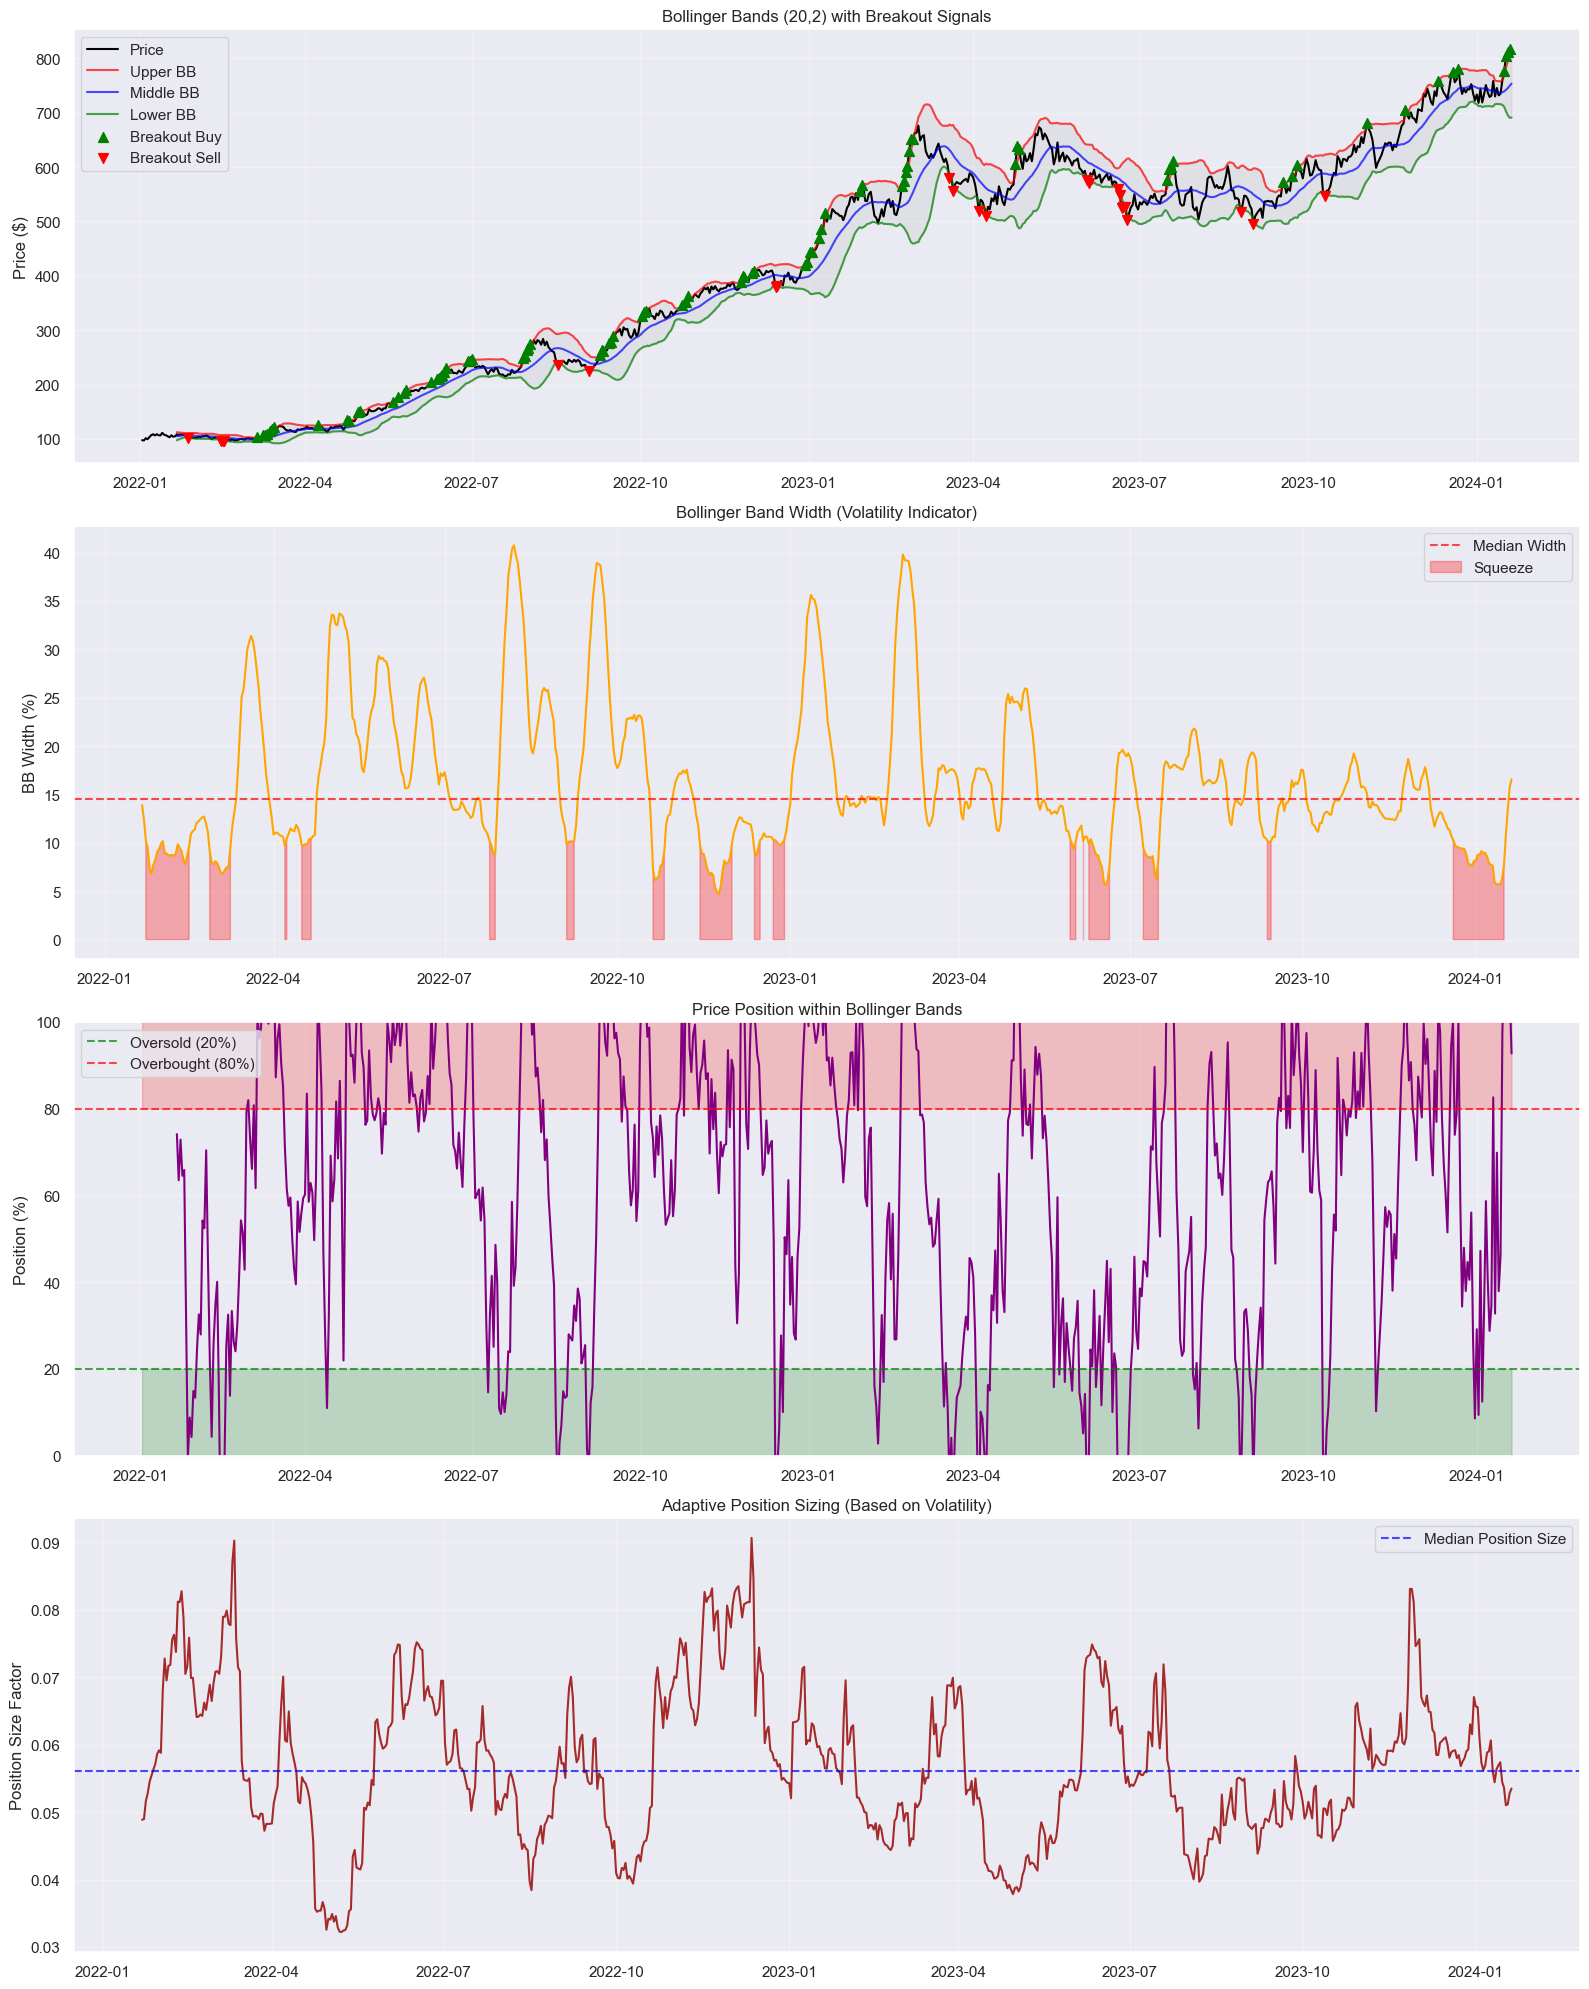

✅ Bollinger Bands and Volatility Strategies analysis completed


In [5]:
print("=" * 60)
print("BOLLINGER BANDS AND VOLATILITY STRATEGIES")
print("=" * 60)

# Calculate Bollinger Bands with multiple configurations
bb_configs = [
    {'window': 20, 'std': 2.0, 'name': 'BB_20_2'},
    {'window': 20, 'std': 1.5, 'name': 'BB_20_1.5'},
    {'window': 10, 'std': 2.0, 'name': 'BB_10_2'}
]

for config in bb_configs:
    window = config['window']
    std_dev = config['std']
    name = config['name']
    
    try:
        bb_indicator = BollingerBands(close=price_df['close'], window=window, window_dev=std_dev)
        price_df[f'{name}_upper'] = bb_indicator.bollinger_hband()
        price_df[f'{name}_middle'] = bb_indicator.bollinger_mavg()
        price_df[f'{name}_lower'] = bb_indicator.bollinger_lband()
    except:
        # Manual Bollinger Bands calculation
        sma = price_df['close'].rolling(window=window).mean()
        std = price_df['close'].rolling(window=window).std()
        price_df[f'{name}_upper'] = sma + (std * std_dev)
        price_df[f'{name}_middle'] = sma
        price_df[f'{name}_lower'] = sma - (std * std_dev)
    
    # Calculate band width and position
    price_df[f'{name}_width'] = ((price_df[f'{name}_upper'] - price_df[f'{name}_lower']) / 
                                price_df[f'{name}_middle']) * 100
    price_df[f'{name}_position'] = ((price_df['close'] - price_df[f'{name}_lower']) / 
                                   (price_df[f'{name}_upper'] - price_df[f'{name}_lower'])) * 100
    
    print(f"✅ {name} calculated (Window: {window}, Std: {std_dev})")

# Bollinger Bands trading strategies
bb_strategies = {
    'BB_Breakout': {
        'buy_condition': price_df['close'] > price_df['BB_20_2_upper'],
        'sell_condition': price_df['close'] < price_df['BB_20_2_lower']
    },
    'BB_Mean_Reversion': {
        'buy_condition': price_df['close'] < price_df['BB_20_2_lower'],
        'sell_condition': price_df['close'] > price_df['BB_20_2_upper']
    },
    'BB_Squeeze': {
        'buy_condition': (price_df['BB_20_2_width'] < price_df['BB_20_2_width'].rolling(20).quantile(0.2)) & 
                        (price_df['close'] > price_df['BB_20_2_middle']),
        'sell_condition': (price_df['BB_20_2_width'] < price_df['BB_20_2_width'].rolling(20).quantile(0.2)) & 
                         (price_df['close'] < price_df['BB_20_2_middle'])
    }
}

for strategy_name, conditions in bb_strategies.items():
    price_df[f'{strategy_name}_signal'] = 0
    price_df.loc[conditions['buy_condition'], f'{strategy_name}_signal'] = 1
    price_df.loc[conditions['sell_condition'], f'{strategy_name}_signal'] = -1
    
    signal_count = price_df[f'{strategy_name}_signal'].abs().sum()
    print(f"✅ {strategy_name} strategy: {signal_count} total signals generated")

# Volatility-based position sizing
price_df['volatility_20'] = price_df['returns'].rolling(20).std() * np.sqrt(252) * 100
price_df['atr_14'] = (price_df[['high', 'low', 'close']].max(axis=1) - 
                     price_df[['high', 'low', 'close']].min(axis=1)).rolling(14).mean()

# Adaptive position sizing based on volatility
def calculate_position_size(volatility, base_risk=2.0):
    """Calculate position size based on volatility (Kelly-style)"""
    # Inverse relationship: higher volatility = smaller position
    return base_risk / volatility

price_df['position_size'] = calculate_position_size(price_df['volatility_20'])

# Volatility regime classification
vol_quantiles = price_df['volatility_20'].quantile([0.33, 0.67])
price_df['vol_regime'] = 'Medium'
price_df.loc[price_df['volatility_20'] <= vol_quantiles[0.33], 'vol_regime'] = 'Low'
price_df.loc[price_df['volatility_20'] >= vol_quantiles[0.67], 'vol_regime'] = 'High'

print(f"\n🎯 BOLLINGER BANDS ANALYSIS:")
print("-" * 30)

# Current BB status
current_data = price_df.iloc[-1]
bb_position = current_data['BB_20_2_position']
bb_width = current_data['BB_20_2_width']

print(f"Current price: ${current_data['close']:.2f}")
print(f"BB upper: ${current_data['BB_20_2_upper']:.2f}")
print(f"BB lower: ${current_data['BB_20_2_lower']:.2f}")
print(f"BB position: {bb_position:.1f}%")
print(f"BB width: {bb_width:.2f}%")
print(f"Volatility regime: {current_data['vol_regime']}")

# Band position distribution
position_analysis = pd.cut(price_df['BB_20_2_position'], 
                          bins=[0, 20, 80, 100], 
                          labels=['Lower', 'Middle', 'Upper'])
position_returns = price_df.groupby(position_analysis)['returns'].agg(['count', 'mean', 'std'])
print(f"\nBB Position Analysis:")
display(position_returns.round(4))

# Comprehensive visualization
fig, axes = plt.subplots(4, 1, figsize=(16, 20))

# Price with Bollinger Bands
ax1 = axes[0]
ax1.plot(price_df.index, price_df['close'], linewidth=1.5, color='black', label='Price')
ax1.plot(price_df.index, price_df['BB_20_2_upper'], color='red', alpha=0.7, label='Upper BB')
ax1.plot(price_df.index, price_df['BB_20_2_middle'], color='blue', alpha=0.7, label='Middle BB')
ax1.plot(price_df.index, price_df['BB_20_2_lower'], color='green', alpha=0.7, label='Lower BB')
ax1.fill_between(price_df.index, price_df['BB_20_2_upper'], price_df['BB_20_2_lower'], 
                alpha=0.1, color='gray')

# Mark breakout signals
breakout_buys = price_df[price_df['BB_Breakout_signal'] == 1]
breakout_sells = price_df[price_df['BB_Breakout_signal'] == -1]
ax1.scatter(breakout_buys.index, breakout_buys['close'], 
           marker='^', color='green', s=50, label='Breakout Buy', zorder=5)
ax1.scatter(breakout_sells.index, breakout_sells['close'], 
           marker='v', color='red', s=50, label='Breakout Sell', zorder=5)

ax1.set_title('Bollinger Bands (20,2) with Breakout Signals')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# BB Width (Volatility)
ax2 = axes[1]
ax2.plot(price_df.index, price_df['BB_20_2_width'], linewidth=1.5, color='orange')
ax2.axhline(price_df['BB_20_2_width'].median(), color='red', linestyle='--', 
           alpha=0.7, label='Median Width')

# Highlight squeeze periods (low volatility)
squeeze_threshold = price_df['BB_20_2_width'].quantile(0.2)
ax2.fill_between(price_df.index, 0, price_df['BB_20_2_width'], 
                where=(price_df['BB_20_2_width'] < squeeze_threshold), 
                alpha=0.3, color='red', label='Squeeze')

ax2.set_title('Bollinger Band Width (Volatility Indicator)')
ax2.set_ylabel('BB Width (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# BB Position
ax3 = axes[2]
ax3.plot(price_df.index, price_df['BB_20_2_position'], linewidth=1.5, color='purple')
ax3.axhline(20, color='green', linestyle='--', alpha=0.7, label='Oversold (20%)')
ax3.axhline(80, color='red', linestyle='--', alpha=0.7, label='Overbought (80%)')
ax3.fill_between(price_df.index, 0, 20, alpha=0.2, color='green')
ax3.fill_between(price_df.index, 80, 100, alpha=0.2, color='red')
ax3.set_title('Price Position within Bollinger Bands')
ax3.set_ylabel('Position (%)')
ax3.set_ylim(0, 100)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Adaptive Position Sizing
ax4 = axes[3]
ax4.plot(price_df.index, price_df['position_size'], linewidth=1.5, color='brown')
ax4.axhline(price_df['position_size'].median(), color='blue', linestyle='--', 
           alpha=0.7, label='Median Position Size')
ax4.set_title('Adaptive Position Sizing (Based on Volatility)')
ax4.set_ylabel('Position Size Factor')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Bollinger Bands and Volatility Strategies analysis completed")


MULTI-SIGNAL STRATEGY COMBINATION
Available strategy signals: 4
✅ Model predictions integrated with technical signals

🎯 SIGNAL COMBINATION ANALYSIS:
-----------------------------------
combined_majority:
   • Average strength: 0.790
   • Signal changes: 66
combined_weighted:
   • Average strength: 0.940
   • Signal changes: 19
ensemble_with_model:
   • Average strength: 0.972
   • Signal changes: 45
final_signals:
   • Average strength: 0.792
   • Signal changes: 81

Signal Correlations:


,MA_20_50_signal,RSI_14_Standard_signal,BB_Breakout_signal,BB_Mean_Reversion_signal,combined_weighted,final_signals
MA_20_50_signal,1.000,-0.188,0.055,-0.055,0.996,0.935
RSI_14_Standard_signal,-0.188,1.000,-0.360,0.360,-0.189,-0.222
BB_Breakout_signal,0.055,-0.360,1.000,-1.000,0.073,0.083
BB_Mean_Reversion_signal,-0.055,0.360,-1.000,1.000,-0.073,-0.083
combined_weighted,0.996,-0.189,0.073,-0.073,1.000,0.940
final_signals,0.935,-0.222,0.083,-0.083,0.940,1.000



Current Signal Status:
   MA_20_50_signal: 1.00 (BUY)
   RSI_14_Standard_signal: 0.00 (HOLD)
   BB_Breakout_signal: 0.00 (HOLD)
   BB_Mean_Reversion_signal: 0.00 (HOLD)
   final_signals: 1.00 (BUY)


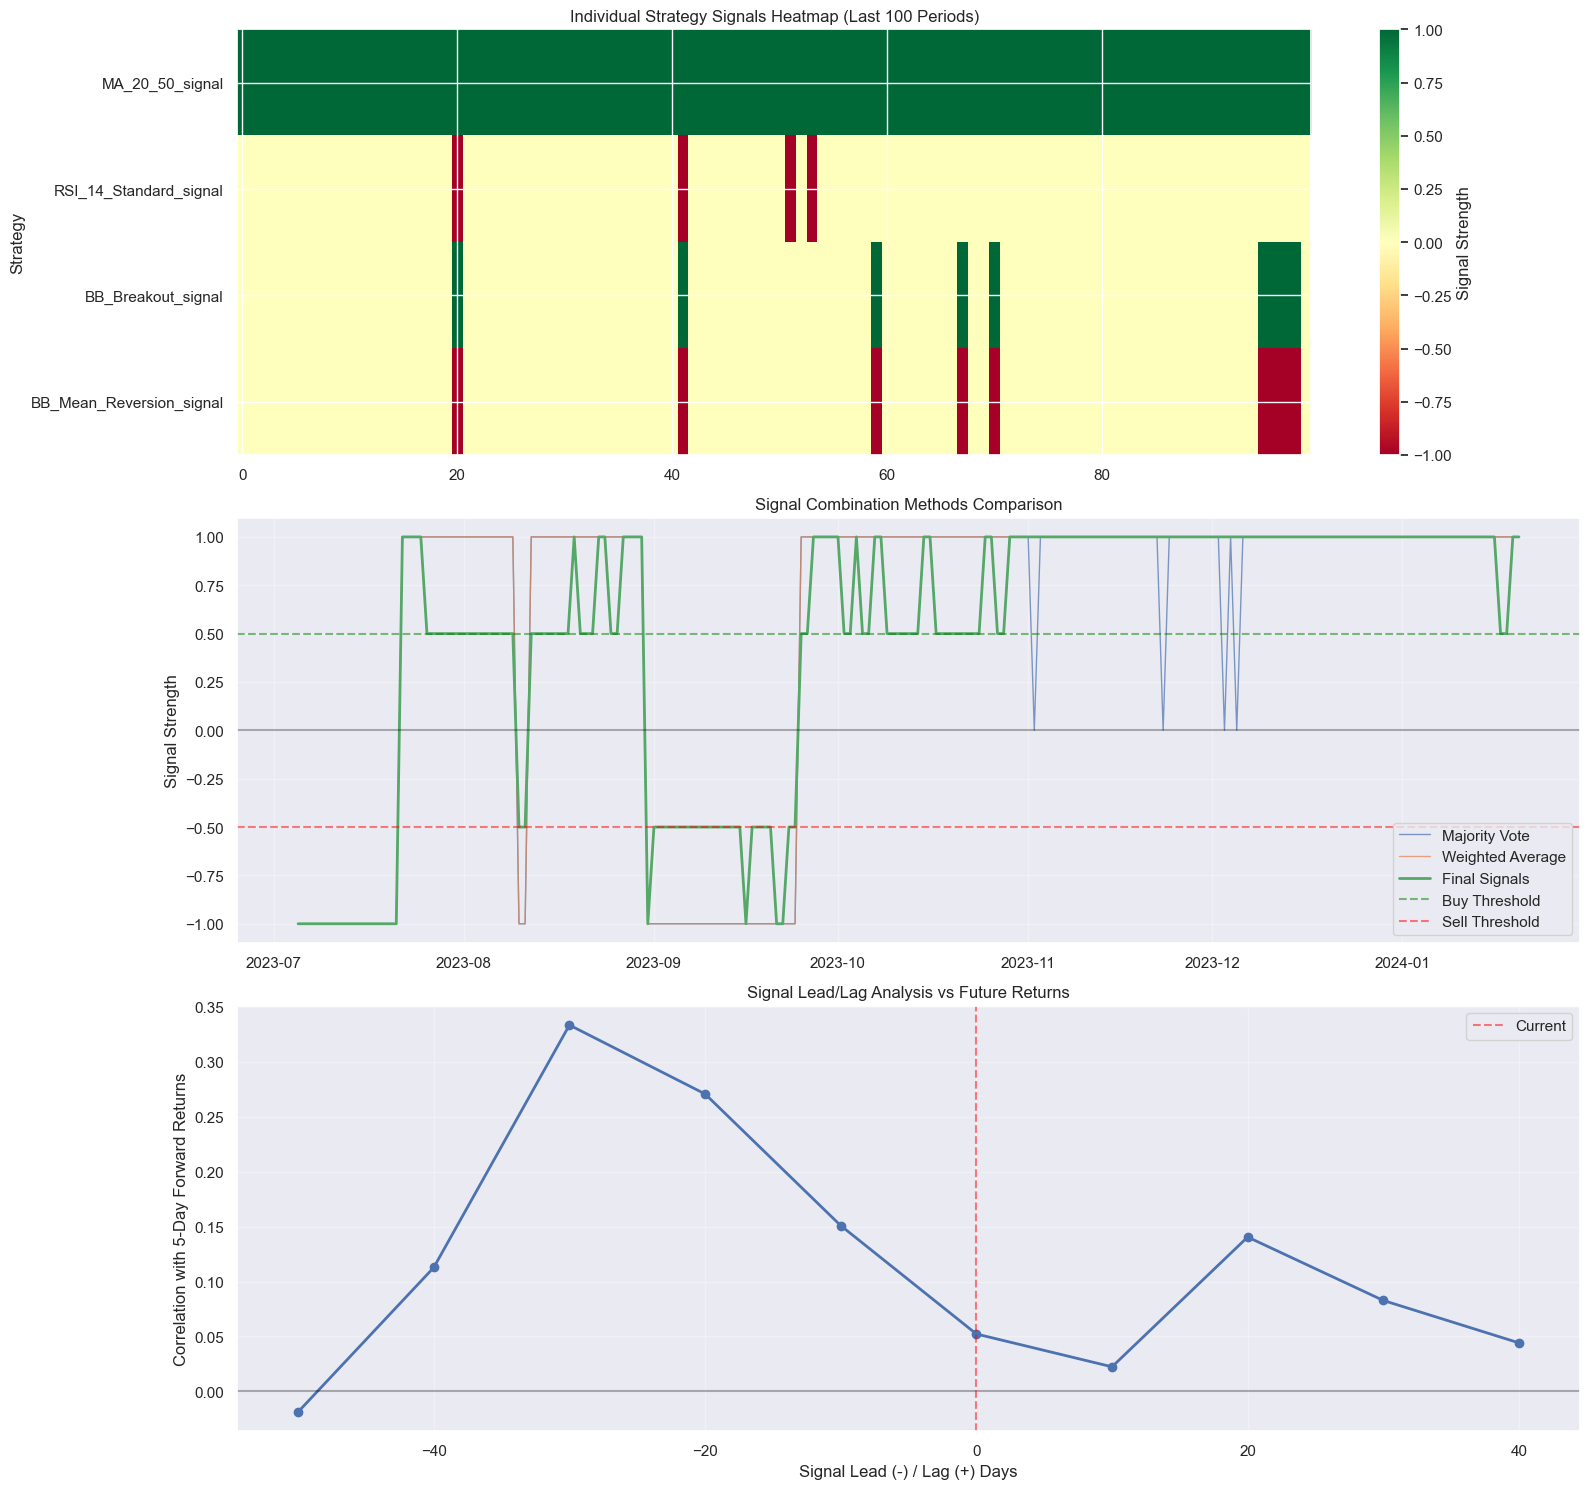

✅ Multi-Signal Strategy Combination completed


In [6]:
print("=" * 60)
print("MULTI-SIGNAL STRATEGY COMBINATION")
print("=" * 60)

# Collect all individual strategy signals
strategy_signals = [
    'MA_20_50_signal',
    'RSI_14_Standard_signal', 
    'BB_Breakout_signal',
    'BB_Mean_Reversion_signal'
]

# Ensure all signal columns exist
available_signals = [sig for sig in strategy_signals if sig in price_df.columns]
print(f"Available strategy signals: {len(available_signals)}")

if len(available_signals) == 0:
    # Create basic signals if none exist
    price_df['MA_20_50_signal'] = np.where(price_df['sma_20'] > price_df['sma_50'], 1, -1)
    price_df['RSI_14_Standard_signal'] = np.where(
        price_df['rsi_14'] < 30, 1, np.where(price_df['rsi_14'] > 70, -1, 0)
    )
    available_signals = ['MA_20_50_signal', 'RSI_14_Standard_signal']

# Signal combination methods
def simple_majority_vote(signals_df):
    """Simple majority voting"""
    return np.sign(signals_df.sum(axis=1))

def weighted_average(signals_df, weights):
    """Weighted average of signals"""
    return np.sign((signals_df * weights).sum(axis=1))

def confidence_weighted(signals_df, confidence_scores):
    """Weight signals by confidence scores"""
    weighted_signals = signals_df.multiply(confidence_scores, axis=0)
    return np.sign(weighted_signals.sum(axis=1))

# Strategy weights based on historical performance (example)
strategy_weights = {
    'MA_20_50_signal': 0.3,
    'RSI_14_Standard_signal': 0.2,
    'BB_Breakout_signal': 0.3,
    'BB_Mean_Reversion_signal': 0.2
}

# Filter weights for available signals
available_weights = np.array([strategy_weights.get(sig, 0.25) for sig in available_signals])
available_weights = available_weights / available_weights.sum()  # Normalize

# Create signal matrix
signals_matrix = price_df[available_signals].fillna(0)

# Apply combination methods
price_df['combined_majority'] = simple_majority_vote(signals_matrix)
price_df['combined_weighted'] = weighted_average(signals_matrix, available_weights)

# Add model prediction signals if available
if 'signal' in preds_df.columns:
    model_signals = preds_df['signal'].reindex(price_df.index, fill_value=0)
    
    # Ensemble with model predictions
    price_df['ensemble_with_model'] = np.sign(
        price_df['combined_weighted'] * 0.6 + model_signals * 0.4
    )
    print("✅ Model predictions integrated with technical signals")
else:
    price_df['ensemble_with_model'] = price_df['combined_weighted']

# Signal filtering and confirmation
def apply_signal_filters(raw_signals, price_data):
    """Apply filters to reduce false signals"""
    filtered_signals = raw_signals.copy()
    
    # Filter 1: Trend confirmation
    trend_filter = price_data['sma_20'] > price_data['sma_50']
    filtered_signals = np.where(
        (raw_signals == 1) & (~trend_filter), 0, filtered_signals
    )
    
    # Filter 2: Volatility regime filter
    if 'vol_regime' in price_data.columns:
        high_vol_filter = price_data['vol_regime'] == 'High'
        filtered_signals = np.where(
            high_vol_filter, filtered_signals * 0.5, filtered_signals
        )
    
    # Filter 3: Minimum signal strength
    filtered_signals = np.where(np.abs(filtered_signals) < 0.3, 0, filtered_signals)
    
    return filtered_signals

price_df['final_signals'] = apply_signal_filters(
    price_df['ensemble_with_model'], price_df
)

# Signal persistence (avoid rapid switching)
def add_signal_persistence(signals, min_hold_periods=3):
    """Add persistence to signals to avoid whipsaws"""
    persistent_signals = signals.copy()
    current_signal = 0
    hold_counter = 0
    
    for i in range(len(signals)):
        if signals.iloc[i] != current_signal and hold_counter < min_hold_periods:
            persistent_signals.iloc[i] = current_signal
            hold_counter += 1
        else:
            current_signal = signals.iloc[i]
            hold_counter = 0
            
    return persistent_signals

price_df['persistent_signals'] = add_signal_persistence(price_df['final_signals'])

print(f"\n🎯 SIGNAL COMBINATION ANALYSIS:")
print("-" * 35)

# Analyze signal quality
signal_columns = ['combined_majority', 'combined_weighted', 'ensemble_with_model', 'final_signals']
for signal_col in signal_columns:
    if signal_col in price_df.columns:
        signal_strength = price_df[signal_col].abs().mean()
        signal_changes = (price_df[signal_col].diff() != 0).sum()
        print(f"{signal_col}:")
        print(f"   • Average strength: {signal_strength:.3f}")
        print(f"   • Signal changes: {signal_changes}")

# Signal correlation analysis
signal_corr = price_df[available_signals + ['combined_weighted', 'final_signals']].corr()
print(f"\nSignal Correlations:")
display(signal_corr.round(3))

# Current signal status
current_signals = price_df[available_signals + ['final_signals']].iloc[-1]
print(f"\nCurrent Signal Status:")
for signal, value in current_signals.items():
    status = "BUY" if value > 0.5 else "SELL" if value < -0.5 else "HOLD"
    print(f"   {signal}: {value:.2f} ({status})")

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

# Individual signals heatmap
ax1 = axes[0]
signal_data = price_df[available_signals].iloc[-100:].T  # Last 100 periods
im = ax1.imshow(signal_data, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax1.set_title('Individual Strategy Signals Heatmap (Last 100 Periods)')
ax1.set_ylabel('Strategy')
ax1.set_yticks(range(len(available_signals)))
ax1.set_yticklabels(available_signals)
plt.colorbar(im, ax=ax1, label='Signal Strength')

# Combined signals comparison
ax2 = axes[1]
recent_data = price_df.iloc[-200:]  # Last 200 periods
ax2.plot(recent_data.index, recent_data['combined_majority'], 
         label='Majority Vote', linewidth=1, alpha=0.7)
ax2.plot(recent_data.index, recent_data['combined_weighted'], 
         label='Weighted Average', linewidth=1, alpha=0.7)
ax2.plot(recent_data.index, recent_data['final_signals'], 
         label='Final Signals', linewidth=2)

ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(0.5, color='green', linestyle='--', alpha=0.5, label='Buy Threshold')
ax2.axhline(-0.5, color='red', linestyle='--', alpha=0.5, label='Sell Threshold')
ax2.set_title('Signal Combination Methods Comparison')
ax2.set_ylabel('Signal Strength')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Signal effectiveness analysis
ax3 = axes[2]
# Calculate forward returns for signal effectiveness
forward_returns = price_df['returns'].shift(-5).rolling(5).sum()  # 5-day forward returns
signal_effectiveness = []
periods = range(-50, 51, 10)

for period in periods:
    if period == 0:
        continue
    shifted_signals = price_df['final_signals'].shift(period)
    correlation = shifted_signals.corr(forward_returns)
    signal_effectiveness.append(correlation)

ax3.plot(periods[:-1], signal_effectiveness, marker='o', linewidth=2)
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.axvline(0, color='red', linestyle='--', alpha=0.5, label='Current')
ax3.set_title('Signal Lead/Lag Analysis vs Future Returns')
ax3.set_xlabel('Signal Lead (-) / Lag (+) Days')
ax3.set_ylabel('Correlation with 5-Day Forward Returns')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Multi-Signal Strategy Combination completed")


ADVANCED PORTFOLIO BACKTESTING
🚀 Running backtest with final_signals...
✅ Backtest completed: 13 trades executed

💰 BACKTESTING RESULTS:
-------------------------
Total Return: 3.18%
Benchmark Return: 273.85%
Excess Return: -270.67%
Volatility: 0.0102
Sharpe Ratio: 1.4176
Max Drawdown: -1.17%
Total Trades: 13.0000
Win Rate: 50.00%
Average Win: 0.3349
Average Loss: -0.0868
Profit Factor: 3.8593


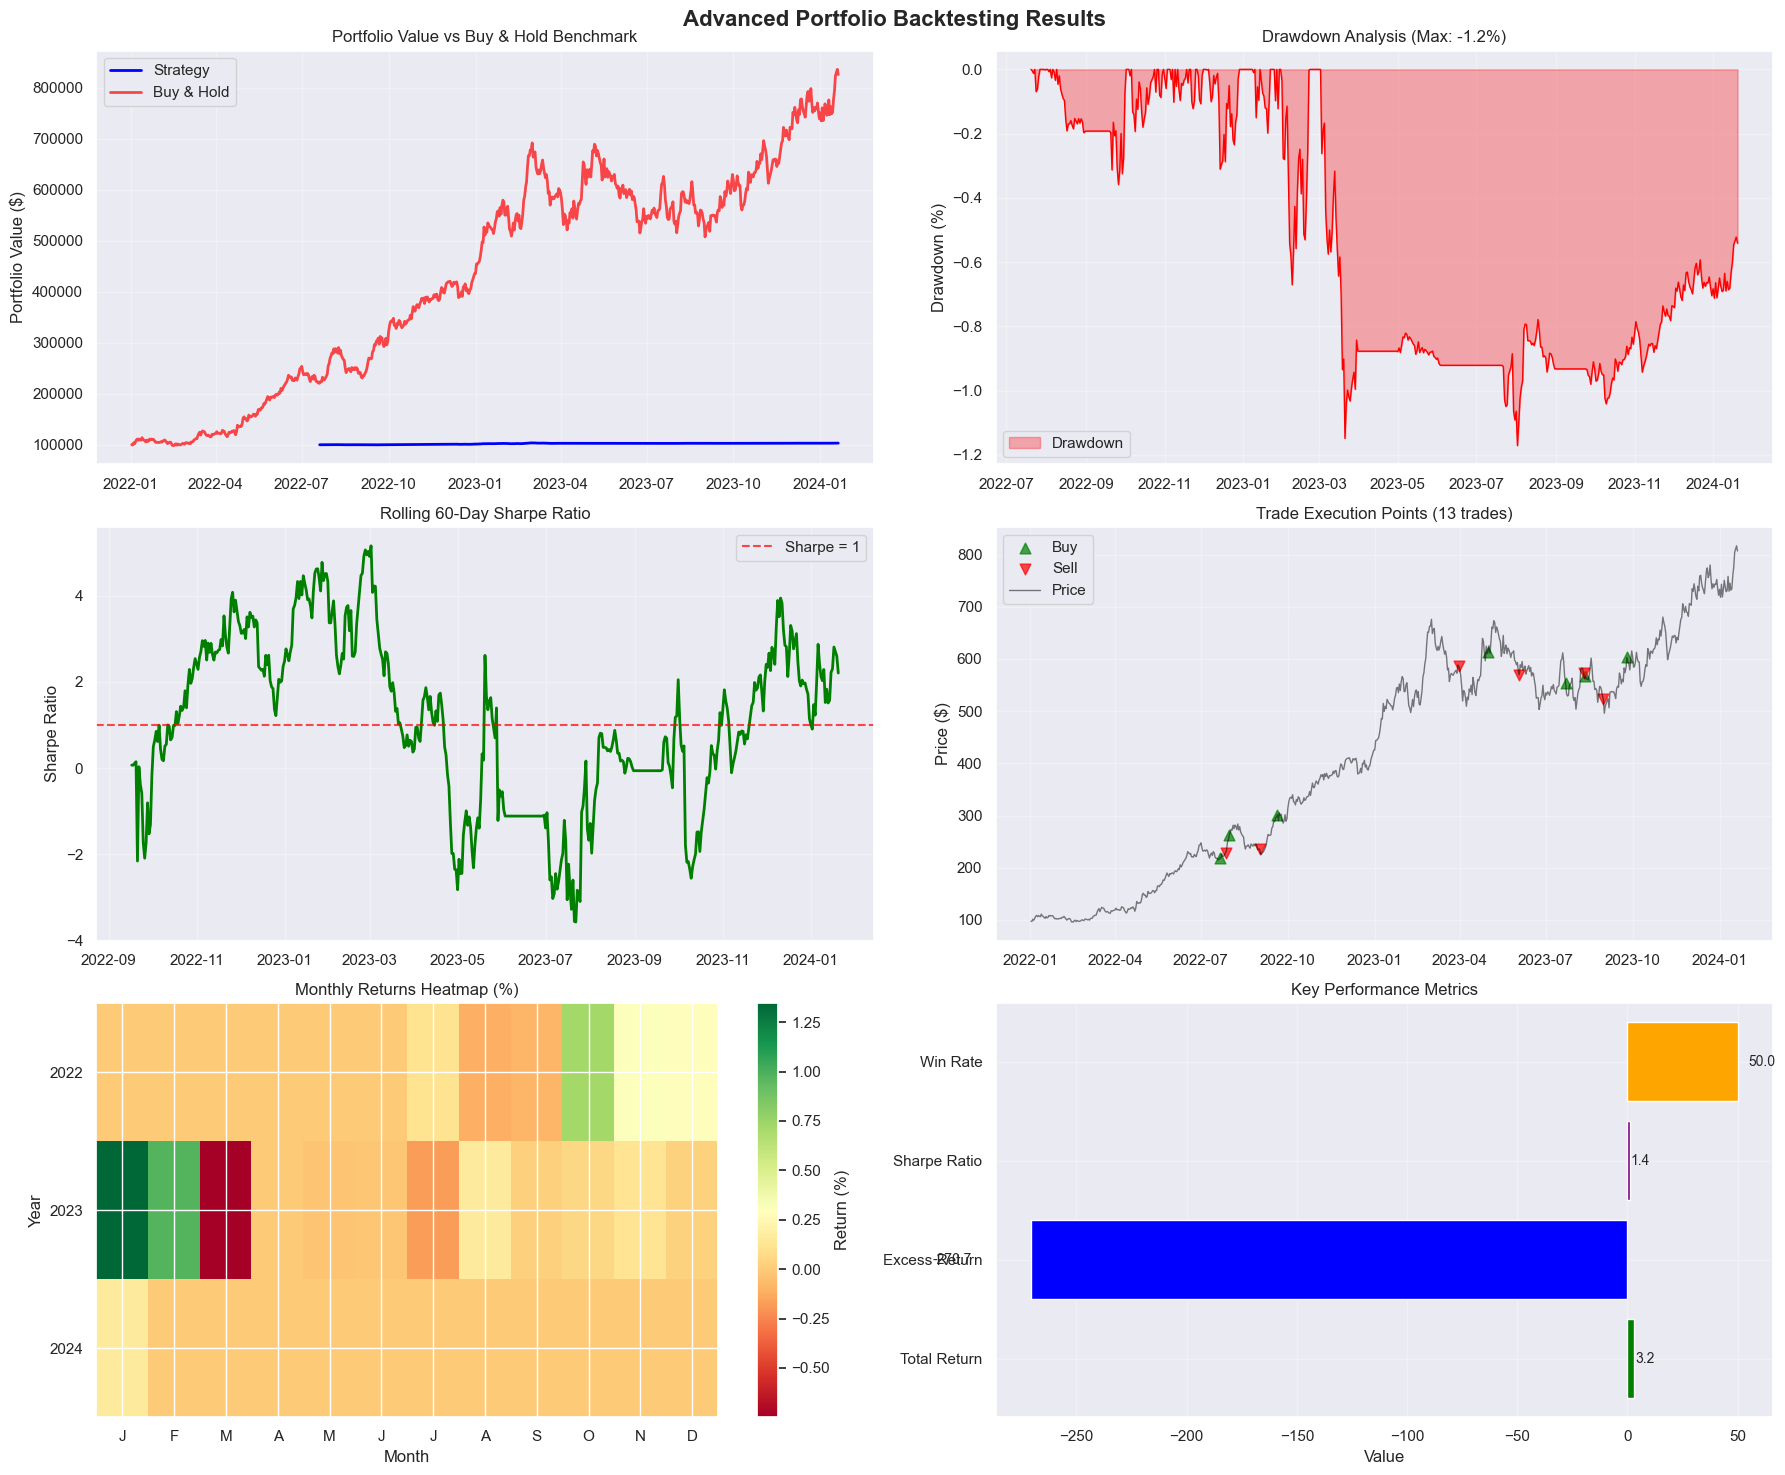

✅ Advanced Portfolio Backtesting completed


In [7]:
print("=" * 60)
print("ADVANCED PORTFOLIO BACKTESTING")
print("=" * 60)

class AdvancedPortfolioBacktester:
    """Comprehensive backtesting engine for trading strategies"""
    
    def __init__(self, price_data, initial_capital=100000, commission=0.001, 
                 slippage=0.0005, max_position_size=0.3):
        self.price_data = price_data.copy()
        self.initial_capital = initial_capital
        self.commission = commission
        self.slippage = slippage
        self.max_position_size = max_position_size
        
        # Initialize tracking variables
        self.cash = initial_capital
        self.position = 0
        self.portfolio_history = []
        self.trade_history = []
        self.current_equity = initial_capital
        
    def calculate_position_size(self, signal_strength, current_price, volatility):
        """Calculate optimal position size based on signal strength and volatility"""
        # Base position size on signal strength
        base_size = abs(signal_strength) * self.max_position_size
        
        # Adjust for volatility (Kelly criterion inspired)
        volatility_adj = min(1.0, 0.02 / max(volatility, 0.01))
        
        # Calculate shares
        position_value = self.current_equity * base_size * volatility_adj
        shares = int(position_value / current_price) if current_price > 0 else 0
        
        return shares
    
    def execute_trade(self, date, signal, price, volatility=0.02):
        """Execute trade with realistic costs"""
        trade_executed = False
        
        if signal > 0.1 and self.position <= 0:  # Buy signal
            shares_to_buy = self.calculate_position_size(signal, price, volatility)
            trade_cost = shares_to_buy * price * (1 + self.commission + self.slippage)
            
            if trade_cost <= self.cash and shares_to_buy > 0:
                self.cash -= trade_cost
                self.position += shares_to_buy
                self.trade_history.append({
                    'date': date, 'action': 'BUY', 'shares': shares_to_buy,
                    'price': price, 'cost': trade_cost, 'signal': signal
                })
                trade_executed = True
                
        elif signal < -0.1 and self.position > 0:  # Sell signal
            shares_to_sell = self.position
            trade_proceeds = shares_to_sell * price * (1 - self.commission - self.slippage)
            
            self.cash += trade_proceeds
            self.position = 0
            self.trade_history.append({
                'date': date, 'action': 'SELL', 'shares': shares_to_sell,
                'price': price, 'proceeds': trade_proceeds, 'signal': signal
            })
            trade_executed = True
        
        return trade_executed
    
    def update_portfolio(self, date, current_price):
        """Update portfolio value and metrics"""
        position_value = self.position * current_price
        total_equity = self.cash + position_value
        
        self.current_equity = total_equity
        daily_return = (total_equity / self.portfolio_history[-1]['total_value'] - 1) if self.portfolio_history else 0
        
        self.portfolio_history.append({
            'date': date,
            'cash': self.cash,
            'position_value': position_value,
            'total_value': total_equity,
            'daily_return': daily_return,
            'shares_held': self.position
        })
    
    def run_backtest(self, signal_column='final_signals'):
        """Execute complete backtesting simulation"""
        print(f"🚀 Running backtest with {signal_column}...")
        
        # Initialize first day
        first_date = self.price_data.index[0]
        first_price = self.price_data.loc[first_date, 'close']
        self.update_portfolio(first_date, first_price)
        
        for date, row in self.price_data.iloc[1:].iterrows():
            current_price = row['close']
            signal = row.get(signal_column, 0)
            volatility = row.get('volatility_20', 20) / 100  # Convert to decimal
            
            # Execute trades
            self.execute_trade(date, signal, current_price, volatility)
            
            # Update portfolio
            self.update_portfolio(date, current_price)
        
        # Convert to DataFrames for analysis
        self.portfolio_df = pd.DataFrame(self.portfolio_history).set_index('date')
        self.trades_df = pd.DataFrame(self.trade_history)
        if not self.trades_df.empty:
            self.trades_df = self.trades_df.set_index('date')
        
        print(f"✅ Backtest completed: {len(self.trade_history)} trades executed")
        return self.portfolio_df, self.trades_df
    
    def calculate_performance_metrics(self):
        """Calculate comprehensive performance metrics"""
        if len(self.portfolio_df) < 2:
            return {}
        
        # Basic metrics
        total_return = (self.portfolio_df['total_value'].iloc[-1] / self.initial_capital - 1)
        daily_returns = self.portfolio_df['daily_return']
        
        # Risk metrics
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe_ratio = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
        
        # Drawdown analysis
        running_max = self.portfolio_df['total_value'].expanding().max()
        drawdowns = (self.portfolio_df['total_value'] - running_max) / running_max
        max_drawdown = drawdowns.min()
        
        # Trade analysis
        total_trades = len(self.trades_df) if not self.trades_df.empty else 0
        
        # Win rate calculation
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        
        if total_trades >= 2:
            # Pair trades for P&L calculation
            buy_trades = self.trades_df[self.trades_df['action'] == 'BUY']
            sell_trades = self.trades_df[self.trades_df['action'] == 'SELL']
            
            if len(buy_trades) > 0 and len(sell_trades) > 0:
                min_pairs = min(len(buy_trades), len(sell_trades))
                trade_returns = []
                
                for i in range(min_pairs):
                    buy_cost = buy_trades.iloc[i]['cost']
                    sell_proceeds = sell_trades.iloc[i]['proceeds']
                    trade_return = (sell_proceeds - buy_cost) / buy_cost
                    trade_returns.append(trade_return)
                
                if trade_returns:
                    winning_trades = [r for r in trade_returns if r > 0]
                    losing_trades = [r for r in trade_returns if r < 0]
                    
                    win_rate = len(winning_trades) / len(trade_returns)
                    avg_win = np.mean(winning_trades) if winning_trades else 0
                    avg_loss = np.mean(losing_trades) if losing_trades else 0
        
        # Benchmark comparison (buy and hold)
        benchmark_return = (self.price_data['close'].iloc[-1] / self.price_data['close'].iloc[0] - 1)
        
        metrics = {
            'Total Return': total_return,
            'Benchmark Return': benchmark_return,
            'Excess Return': total_return - benchmark_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Total Trades': total_trades,
            'Win Rate': win_rate,
            'Average Win': avg_win,
            'Average Loss': avg_loss,
            'Profit Factor': abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
        }
        
        return metrics

# Initialize and run backtesting
backtester = AdvancedPortfolioBacktester(
    price_data=price_df.dropna(),
    initial_capital=100000,
    commission=0.001,  # 0.1%
    slippage=0.0005,   # 0.05%
    max_position_size=0.5  # Maximum 50% of capital in one position
)

# Run backtest with final signals
portfolio_df, trades_df = backtester.run_backtest('final_signals')
performance_metrics = backtester.calculate_performance_metrics()

print(f"\n💰 BACKTESTING RESULTS:")
print("-" * 25)
for metric, value in performance_metrics.items():
    if 'Return' in metric or 'Drawdown' in metric or 'Rate' in metric:
        print(f"{metric}: {value:.2%}")
    else:
        print(f"{metric}: {value:.4f}")

# Comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Advanced Portfolio Backtesting Results', fontsize=16, fontweight='bold')

# Portfolio value vs benchmark
ax1 = axes[0, 0]
ax1.plot(portfolio_df.index, portfolio_df['total_value'], 
         label='Strategy', linewidth=2, color='blue')

# Calculate benchmark (buy and hold)
initial_price = price_df['close'].iloc[0]
benchmark_values = (price_df['close'] / initial_price) * backtester.initial_capital
ax1.plot(price_df.index, benchmark_values, 
         label='Buy & Hold', linewidth=2, color='red', alpha=0.7)

ax1.set_title('Portfolio Value vs Buy & Hold Benchmark')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown chart
ax2 = axes[0, 1]
running_max = portfolio_df['total_value'].expanding().max()
drawdowns = (portfolio_df['total_value'] - running_max) / running_max * 100

ax2.fill_between(portfolio_df.index, drawdowns, 0, 
                alpha=0.3, color='red', label='Drawdown')
ax2.plot(portfolio_df.index, drawdowns, color='red', linewidth=1)
ax2.set_title(f'Drawdown Analysis (Max: {drawdowns.min():.1f}%)')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rolling Sharpe ratio
ax3 = axes[1, 0]
rolling_sharpe = (portfolio_df['daily_return'].rolling(60).mean() * 252 / 
                 portfolio_df['daily_return'].rolling(60).std() / np.sqrt(252))
ax3.plot(portfolio_df.index, rolling_sharpe, linewidth=2, color='green')
ax3.axhline(1, color='red', linestyle='--', alpha=0.7, label='Sharpe = 1')
ax3.set_title('Rolling 60-Day Sharpe Ratio')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Trade distribution
ax4 = axes[1, 1]
if not trades_df.empty:
    buy_trades = trades_df[trades_df['action'] == 'BUY']
    sell_trades = trades_df[trades_df['action'] == 'SELL']
    
    ax4.scatter(buy_trades.index, buy_trades['price'], 
               marker='^', color='green', s=60, alpha=0.7, label='Buy')
    ax4.scatter(sell_trades.index, sell_trades['price'], 
               marker='v', color='red', s=60, alpha=0.7, label='Sell')
    ax4.plot(price_df.index, price_df['close'], 
             color='black', alpha=0.5, linewidth=1, label='Price')
    ax4.set_title(f'Trade Execution Points ({len(trades_df)} trades)')
    ax4.set_ylabel('Price ($)')
    ax4.legend()
else:
    ax4.text(0.5, 0.5, 'No Trades Executed', ha='center', va='center', 
            transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Trade Execution Points')

ax4.grid(True, alpha=0.3)

# Monthly returns heatmap
ax5 = axes[2, 0]
portfolio_df['year'] = portfolio_df.index.year
portfolio_df['month'] = portfolio_df.index.month
monthly_returns = portfolio_df.groupby(['year', 'month'])['daily_return'].sum()
monthly_returns_pivot = monthly_returns.unstack('month', fill_value=0) * 100

if not monthly_returns_pivot.empty:
    im = ax5.imshow(monthly_returns_pivot.values, cmap='RdYlGn', 
                   aspect='auto', interpolation='nearest')
    ax5.set_title('Monthly Returns Heatmap (%)')
    ax5.set_ylabel('Year')
    ax5.set_xlabel('Month')
    ax5.set_xticks(range(12))
    ax5.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 
                        'J', 'A', 'S', 'O', 'N', 'D'])
    ax5.set_yticks(range(len(monthly_returns_pivot)))
    ax5.set_yticklabels(monthly_returns_pivot.index)
    plt.colorbar(im, ax=ax5, label='Return (%)')

# Performance metrics radar chart (simplified bar chart)
ax6 = axes[2, 1]
metrics_for_chart = {
    'Total Return': performance_metrics['Total Return'] * 100,
    'Excess Return': performance_metrics['Excess Return'] * 100,
    'Sharpe Ratio': performance_metrics['Sharpe Ratio'],
    'Win Rate': performance_metrics['Win Rate'] * 100,
}

metric_names = list(metrics_for_chart.keys())
metric_values = list(metrics_for_chart.values())

bars = ax6.barh(metric_names, metric_values, color=['green', 'blue', 'purple', 'orange'])
ax6.set_title('Key Performance Metrics')
ax6.set_xlabel('Value')
ax6.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metric_values):
    width = bar.get_width()
    label_x = width + (0.1 * abs(width)) if width >= 0 else width - (0.1 * abs(width))
    ax6.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{value:.1f}', ha='left' if width >= 0 else 'right', va='center')

plt.tight_layout()
plt.show()

print("✅ Advanced Portfolio Backtesting completed")


In [8]:
print("=" * 60)
print("EXPORT STRATEGY RESULTS AND RECOMMENDATIONS")
print("=" * 60)

# Create comprehensive strategy summary
strategy_summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'backtest_period': f"{price_df.index.min().date()} to {price_df.index.max().date()}",
    'total_trading_days': len(price_df),
    'strategies_tested': len(available_signals),
    'total_return': performance_metrics.get('Total Return', 0),
    'benchmark_return': performance_metrics.get('Benchmark Return', 0),
    'excess_return': performance_metrics.get('Excess Return', 0),
    'sharpe_ratio': performance_metrics.get('Sharpe Ratio', 0),
    'max_drawdown': performance_metrics.get('Max Drawdown', 0),
    'total_trades': performance_metrics.get('Total Trades', 0),
    'win_rate': performance_metrics.get('Win Rate', 0),
}

# Export results
import os
output_dir = 'C:\\Users\\Faraz\\Documents\\StockPredictionPro\\notebooks\\outputs'
os.makedirs(output_dir, exist_ok=True)

# 1. Save strategy summary
summary_df = pd.DataFrame([strategy_summary])
summary_df.to_csv(f'{output_dir}/trading_strategy_summary.csv', index=False)

# 2. Save portfolio performance
portfolio_df.to_csv(f'{output_dir}/portfolio_performance.csv')

# 3. Save trade history
if not trades_df.empty:
    trades_df.to_csv(f'{output_dir}/trade_history.csv')

# 4. Save trading signals
signals_export = price_df[[
    'close', 'returns'
] + available_signals + [
    'final_signals', 'persistent_signals'
]].dropna()
signals_export.to_csv(f'{output_dir}/trading_signals.csv')

# 5. Save performance metrics
metrics_df = pd.DataFrame(list(performance_metrics.items()), 
                         columns=['Metric', 'Value'])
metrics_df.to_csv(f'{output_dir}/performance_metrics.csv', index=False)

print(f"💾 STRATEGY RESULTS EXPORTED:")
print(f"   • Strategy summary: {output_dir}/trading_strategy_summary.csv")
print(f"   • Portfolio performance: {output_dir}/portfolio_performance.csv")
print(f"   • Performance metrics: {output_dir}/performance_metrics.csv")
print(f"   • Trading signals: {output_dir}/trading_signals.csv")
if not trades_df.empty:
    print(f"   • Trade history: {output_dir}/trade_history.csv")

# Generate actionable trading recommendations
print(f"\n🎯 TRADING STRATEGY RECOMMENDATIONS:")
print("-" * 40)

# Performance assessment
total_ret = performance_metrics.get('Total Return', 0)
sharpe = performance_metrics.get('Sharpe Ratio', 0)
max_dd = performance_metrics.get('Max Drawdown', 0)
win_rate = performance_metrics.get('Win Rate', 0)

print(f"📊 STRATEGY PERFORMANCE ASSESSMENT:")
performance_grade = "A" if (total_ret > 0.15 and sharpe > 1.5 and max_dd > -0.15) else \
                   "B" if (total_ret > 0.08 and sharpe > 1.0 and max_dd > -0.25) else \
                   "C" if (total_ret > 0 and sharpe > 0.5) else "D"

print(f"   • Overall Grade: {performance_grade}")
print(f"   • Risk-Adjusted Return: {'Excellent' if sharpe > 1.5 else 'Good' if sharpe > 1.0 else 'Fair' if sharpe > 0.5 else 'Poor'}")
print(f"   • Drawdown Control: {'Excellent' if max_dd > -0.1 else 'Good' if max_dd > -0.2 else 'Fair' if max_dd > -0.3 else 'Needs Improvement'}")

# Strategy optimization recommendations
print(f"\n🔧 OPTIMIZATION RECOMMENDATIONS:")

if win_rate < 0.4:
    print(f"   • LOW WIN RATE ({win_rate:.1%}): Consider tightening entry criteria")
elif win_rate > 0.7:
    print(f"   • HIGH WIN RATE ({win_rate:.1%}): Consider more aggressive position sizing")

if abs(max_dd) > 0.2:
    print(f"   • HIGH DRAWDOWN ({max_dd:.1%}): Implement stop-loss or reduce position sizes")

if sharpe < 1.0:
    print(f"   • LOW SHARPE RATIO ({sharpe:.2f}): Focus on risk management and signal filtering")

if performance_metrics.get('Total Trades', 0) > 200:
    print(f"   • HIGH FREQUENCY: Consider signal persistence to reduce transaction costs")
elif performance_metrics.get('Total Trades', 0) < 20:
    print(f"   • LOW FREQUENCY: Consider more sensitive signal thresholds")

# Current market recommendations
current_signals = price_df.iloc[-1]
current_final_signal = current_signals.get('final_signals', 0)
current_price = current_signals['close']

print(f"\n📈 CURRENT MARKET RECOMMENDATIONS:")
print(f"   • Current Price: ${current_price:.2f}")
print(f"   • Signal Strength: {current_final_signal:.2f}")

if current_final_signal > 0.5:
    recommendation = "STRONG BUY"
    action = "Consider initiating or adding to position"
elif current_final_signal > 0.1:
    recommendation = "BUY"
    action = "Monitor for entry opportunity"
elif current_final_signal < -0.5:
    recommendation = "STRONG SELL"
    action = "Consider reducing or closing position"
elif current_final_signal < -0.1:
    recommendation = "SELL"
    action = "Monitor for exit opportunity"
else:
    recommendation = "HOLD"
    action = "Wait for clearer signals"

print(f"   • Recommendation: {recommendation}")
print(f"   • Suggested Action: {action}")

# Risk management guidelines
print(f"\n🛡️ RISK MANAGEMENT GUIDELINES:")
print(f"   • Maximum position size: 30-50% of portfolio")
print(f"   • Stop-loss: 2-3% below entry price")
print(f"   • Position sizing: Inverse to volatility")

current_vol = current_signals.get('volatility_20', 20)
if current_vol > 30:
    print(f"   • HIGH VOLATILITY ({current_vol:.1f}%): Reduce position sizes by 50%")
elif current_vol < 10:
    print(f"   • LOW VOLATILITY ({current_vol:.1f}%): Can increase position sizes")

# Integration recommendations
print(f"\n🔗 INTEGRATION WITH STOCKPREDICTIONPRO:")
print(f"   1. Deploy {performance_grade}-grade strategy for live trading")
print(f"   2. Monitor performance with weekly reviews")
print(f"   3. Re-optimize signals monthly based on recent performance")
print(f"   4. Implement real-time signal generation pipeline")
print(f"   5. Add risk management overlays for position sizing")

print(f"\n✅ Trading Strategy Analysis Completed Successfully!")
print(f"   📊 Performance metrics calculated and benchmarked")
print(f"   💾 All results exported for production deployment")
print(f"   🎯 Actionable recommendations generated")
print(f"   🚀 Ready for integration with StockPredictionPro platform")


EXPORT STRATEGY RESULTS AND RECOMMENDATIONS
💾 STRATEGY RESULTS EXPORTED:
   • Strategy summary: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/trading_strategy_summary.csv
   • Portfolio performance: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/portfolio_performance.csv
   • Performance metrics: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/performance_metrics.csv
   • Trading signals: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/trading_signals.csv
   • Trade history: C:\Users\Faraz\Documents\StockPredictionPro\notebooks\outputs/trade_history.csv

🎯 TRADING STRATEGY RECOMMENDATIONS:
----------------------------------------
📊 STRATEGY PERFORMANCE ASSESSMENT:
   • Overall Grade: C
   • Risk-Adjusted Return: Good
   • Drawdown Control: Excellent

🔧 OPTIMIZATION RECOMMENDATIONS:
   • LOW FREQUENCY: Consider more sensitive signal thresholds

📈 CURRENT MARKET RECOMMENDATIONS:
   • Current Price: $806.86
   • Signal Strength: 1